# tmp
this is just a dump for testing

In [46]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
sys.path.insert(0, '../../icenumerics/')
sys.path.insert(0, './auxnumerics/')
sys.path.insert(0, './testing/')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo_colloids as mc

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice


In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [37]:
testno = 'test03'
size = 10
data_path = f'../data/{testno}/{size}'
targetdir = os.path.join(data_path,'frames')

trj = pd.read_csv(os.path.join(data_path,'trj','xtrj1.csv'),index_col=['frame','id'])
vertices = pd.read_csv(os.path.join(data_path,'vertices','vertices1.csv'),index_col=['frame','vertex'])

v = ice.vertices()
v.vertices = vertices
v.vertices

x      y  coordination  charge   dx   dy
frame  vertex                                              
0.0    0.0       0.0    0.0           4.0     0.0  0.0  0.0
       1.0      30.0    0.0           4.0     0.0  0.0  0.0
       2.0      60.0    0.0           4.0     0.0  0.0  0.0
       3.0      90.0    0.0           4.0     0.0  0.0  0.0
       4.0     120.0    0.0           4.0     0.0  0.0  0.0
...              ...    ...           ...     ...  ...  ...
3599.0 95.0    150.0  270.0           4.0     0.0  0.0  0.0
       96.0    180.0  270.0           4.0     0.0  0.0  0.0
       97.0    210.0  270.0           4.0     0.0  0.0  0.0
       98.0    240.0  270.0           4.0     0.0  0.0  0.0
       99.0    270.0  270.0           4.0     0.0  0.0  0.0

[360000 rows x 6 columns]

In [90]:
from field_test03 import fx,fy,fz
time = trj.t.unique()

In [91]:
def lmp_to_numpy(string):
    string = string.replace('sin','np.sin')
    string = string.replace('cos','np.cos')
    string = string.replace('PI','np.pi')
    string = string.replace('e6','')
    return string

def join_field_component(fi):
    return "".join( list( map(lmp_to_numpy,fi) ) )

In [93]:
v_Bmag = params['max_field'].magnitude
nfx = eval(join_field_component(fx))
nfy = eval(join_field_component(fy))
nfz = eval(join_field_component(fz))

In [108]:
from mpl_toolkits.mplot3d import Axes3D
len(time)

3600

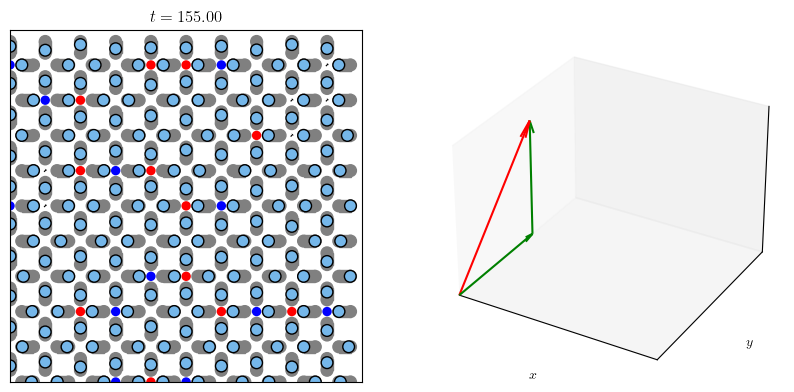

In [114]:
frame = 3100

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(121)

region_limit = size*params['lattice_constant'].magnitude
ice.draw_frame(trj, frame_no=frame,
               region=[0,region_limit,0,region_limit],
               radius=params["particle_radius"].magnitude,
               cutoff=params["trap_sep"].magnitude/2,
               particle_color='#75b7ea',
               trap_color='gray',
               ax = ax)

v.display(ax,sl=frame)
ax.set_title(f'$t = {frame/20:1.2f}$')

ax2  = fig.add_subplot(122,projection='3d')
ax2.quiver(
    0,0,0,  # Starting point
    nfx[frame], nfy[frame], nfz[frame],  # Direction
    length=1,  # Length of the arrow
    color='r',  # Color of the arrow
    arrow_length_ratio=0.1  # Ratio of the arrow head
)

ax2.quiver(
    0,0,0,  # Starting point
    nfx[frame], 0, 0,  # X projection
    color='g',  # Color of the X projection
    arrow_length_ratio=0.1
)

ax2.quiver(
    nfx[frame],0,0,
    0, 1, 0,
    length = nfy[frame],
    color='g',
    arrow_length_ratio=0.1
)

ax2.quiver(
    nfx[frame],nfy[frame],0,
    0, 0, 1,
    length = nfz[frame],
    color='g',
    arrow_length_ratio=0.1
)

ax2.set_xlim([0, 10])
ax2.set_ylim([0, 10])
ax2.set_zlim([0, 10])

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])

ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_zticklabels([])

ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_zlabel('$z$')

plt.show()

In [103]:
nfy[frame]

0.0